In [1]:
%matplotlib inline
import importlib
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional, GlobalAveragePooling2D
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras_tqdm import TQDMNotebookCallback
from keras.models import load_model

Using TensorFlow backend.


In [2]:
%cd ~/dlcookbook/dlusecases/xray_chests/

/home/ubuntu/dlcookbook/dlusecases/xray_chests


In [3]:
PATH = './data/ChinaSet_AllFiles/CXR_png/'

# 1 Summary

This notebook creates a DenseNet, which process images of x-ray chests. The implementation can predict if a patient is sick/anamoly with ~70% accuracy. <br><br>The data are part of the Shenzhen Hospital X-ray Set <a href='https://openi.nlm.nih.gov/'>Officiel Site</a> and <a href='http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip'>Direct download</a>:<br>
<ul>
  <li>662 XRay Images</li>
</ul>
<br><br>The main idea is to use the <a href='https://arxiv.org/abs/1608.06993'>DenseNet</a> and train it for XRay Images. The architecture of DenseNet showed that it worked well on small data sets.<br><br>
<img src='./src/densenet.jpg'><br><br>

The DenseNet is able to learn basic pattern with small amount of data size.

Resources:<br>
<ul>
  <li><a href='https://arxiv.org/abs/1608.06993'>DenseNet</a></li>
  <li><a href='https://openi.nlm.nih.gov/'>Open Access Biomedical Image Search Engine</a></li> 
</ul>


Keywords: Deep Learning, DenseNet, XRay, Chest

# Data Processing

In [4]:
fnames = glob.glob(PATH+'*.png')

In [5]:
lnames = [0 if '_0.png' in x else 1 for x in fnames]

In [6]:
lnames = np.array(lnames)

In [7]:
img_sz = (100,100)

In [8]:
def to_rgb1(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

In [9]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [10]:
def open_image(fn): 
    image = cv2.imread(fn)
    image = cv2.resize(image, img_sz)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = to_rgb1(gray_image)
    return gray_image

In [11]:
imgs = np.stack([open_image(fn) for fn in fnames])

In [12]:
imgs = imgs/255.

In [13]:
imgs_mean = np.mean(imgs)
imgs_var = np.var(imgs)

In [14]:
imgs-=imgs_mean
imgs/=math.sqrt(imgs_var)

In [15]:
imgs = np.reshape(imgs, (662,100,100,3))

In [16]:
imgs.shape

(662, 100, 100, 3)

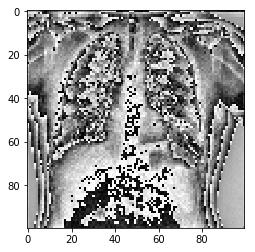

In [17]:
plt.imshow(np.reshape(imgs[0],(100,100,3)))

In [18]:
x = np.arange(662)
np.random.shuffle(x)

In [19]:
imgs_train = imgs[x[:500],]
lnames_train = lnames[x[:500],]
imgs_val = imgs[x[500:],]
lnames_val = lnames[x[500:],]

# Dense Net

In [20]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=0, axis=-1)(x)
def relu_bn(x): return relu(bn(x))

In [21]:
def conv(x, nf, sz, wd, p):
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                          W_regularizer=l2(wd))(x)
    return dropout(x,p)

In [22]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck: x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p)

In [23]:
def transition_block(x, compression=1.0, p=None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x)
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

In [24]:
def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck: nb_layers //= 2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = merge([x,b], mode='concat', concat_axis=-1)
    return x

In [25]:
def create_dense_net(nb_classes, img_input, depth=40, nb_block=3, 
     growth_rate=12, nb_filter=16, bottleneck=False, compression=0.0, p=None, wd=0):

    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    for i,block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(nb_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)

    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation='softmax', W_regularizer=l2(wd))(x)

In [26]:
input_shape = (100,100,3)

In [27]:
img_input = Input(shape=input_shape)

In [28]:
x = create_dense_net(2, img_input, depth=40, nb_filter=16, compression=0.5, bottleneck=True, p=0.2, wd=1e-4)

In [29]:
model = Model(img_input, x)

In [30]:
model.compile(loss='sparse_categorical_crossentropy', 
      optimizer=keras.optimizers.SGD(0.01, 0.9, nesterov=True), metrics=["accuracy"])

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 100, 100, 16)  448         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 100, 100, 16)  64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 100, 100, 16)  0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [32]:
model.fit(imgs_train, lnames_train, batch_size=16, nb_epoch=5, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],  validation_data=(imgs_val, lnames_val))

In [33]:
K.set_value(model.optimizer.lr, 0.003)

In [34]:
model.fit(imgs_train, lnames_train, batch_size=16, nb_epoch=5, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],  validation_data=(imgs_val, lnames_val))